# Person Segmentation Netowork

### Import necessary python lib

- set ImageFile.LOAD_TRUNCATED_IMAGES = True to avoid warinings while training. 
- data module contains all the image generator module functions for training

In [18]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import segmentation_models as sm
import sys
sys.path.append("..")
from seg_net.data import *
from seg_net.gunet import Unet
import keras

## Set Model Params

In [2]:
INPUT_SHAPE =  (256,256,4) #(768,768,3) (512,512,3) (256,256,3)
NUM_CLASS = 1
BACKBONE = 'mobilenetv2'
MODEL_NAME = 'GT_Unet'
LOSS_METRICS = 'BCE_ACC_IOU'
ACTIVATION = 'sigmoid'
DATASET = "train_matte"
IMGNORM = 'divide'
MODEL_PATH = '../results/Models'

model_fname = '{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}'.format(BACKBONE,
                                                MODEL_NAME,
                                                LOSS_METRICS,
                                                IMGNORM,
                                                NUM_CLASS,
                                                ACTIVATION,
                                                INPUT_SHAPE[0],
                                                DATASET)
keras_filename = '{}.hdf5'.format(model_fname)

print(keras_filename)

temporal = True
pretrained = None
pretrained = '/media/new_hdd2/seg_net/results/Models/mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_256_train_matte.hdf5'

mobilenetv2_GT_Unet_BCE_ACC_IOU_divide_1_sigmoid_256_train_matte.hdf5


## Build Model

In [7]:
model = Unet(pretrained = pretrained,
             backbone = BACKBONE,
             input_shape = INPUT_SHAPE,
             classes = NUM_CLASS,
             activation = ACTIVATION,
             sep_conv = True,
             densenet_matting_filters = 128,
             densenet_matting_layers = 3,
             matt_sep_conv = True,
             freeze_encoder = False,
             decoder_filters = (256,128,64,32,16),
             n_upsample_blocks=5)

Instructions for updating:
Colocations handled automatically by placer.


../seg_net/mobilenet_v2.py:319: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


LOADING  /media/new_hdd2/seg_net/results/Models/mobilenetv2_GUnet_BCE_ACC_IOU_divide_1_sigmoid_256_train_matte.hdf5


In [8]:
for layer in model.layers[5:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [9]:
model.compile('sgd', loss=sm.losses.bce_dice_loss, metrics=['accuracy',sm.metrics.iou_score])
#model.compile('Adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile('sgd', loss='mean_squared_error', metrics=['accuracy',sm.metrics.iou_score])

In [11]:
#model.load_weights(os.path.join(MODEL_PATH,keras_filename))
print("Loading from ",os.path.join(MODEL_PATH,keras_filename))

Loading from  ../results/Models/mobilenetv2_GT_Unet_BCE_ACC_IOU_divide_1_sigmoid_256_train_matte.hdf5


In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1_custom_input (Conv2D)     (None, 128, 128, 32) 1152        Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1_custom_input[0][0]         
__________________________________________________________________________________________________
Conv1_relu

### Create Train and validation Image generators , keras callbacks to save model, learning rate scheduler and tensorboard monitoring.

In [3]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

myGene = trainGenerator(1,'../data/raw/train/{}'.format(DATASET),'images','annotations',
                        data_gen_args,save_to_dir = None,
                        target_size = INPUT_SHAPE[:2],
                        imgNorm=IMGNORM , 
                        binary = True if DATASET=='train_person' else False,
                        num_class = NUM_CLASS, 
                        multiclass = True if NUM_CLASS>1 else False,
                        alpha = True if DATASET=='train_matte' else False,
                        temp_aug = temporal)

'''
valGene = validationGenerator(1,'../data/raw/train/train_matte','images','annotations',
                            save_to_dir = None,
                            target_size = INPUT_SHAPE[:2],
                            imgNorm=IMGNORM, 
                            binary = True if DATASET=='train_person' else False,
                            num_class = NUM_CLASS, 
                            multiclass = True if NUM_CLASS>1 else False,
                            alpha = True if DATASET=='train_matte' else False,
                            temp_aug = temporal)
'''

model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(MODEL_PATH,keras_filename), 
                                                   monitor='loss',
                                                   verbose=1, 
                                                   save_best_only=True)

#tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./log', histogram_freq=0, write_graph=True, write_images=True)

lr_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)

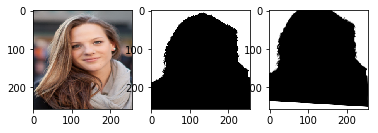

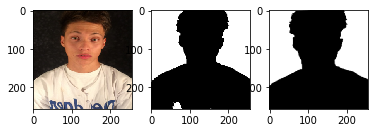

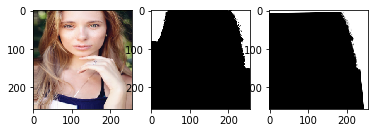

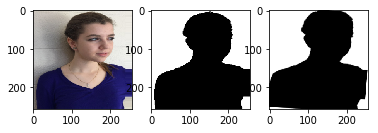

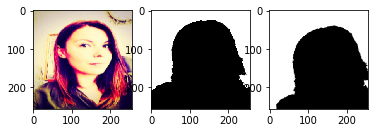

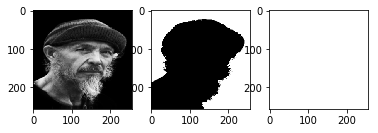

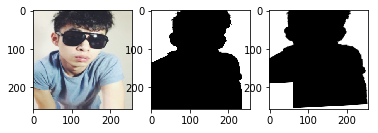

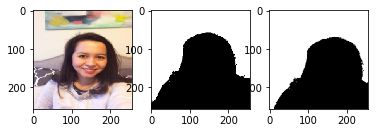

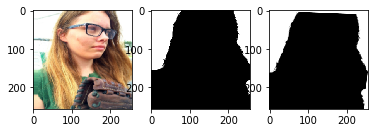

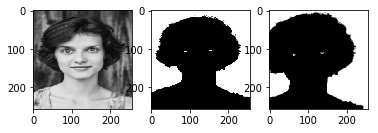

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(10):
    inp,otp = next(myGene)
    if temporal:
        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(inp[0,:,:,:-1])
        axarr[2].imshow(inp[0,:,:,-1], cmap='Greys',  interpolation='nearest')
    else:
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(inp[0,:,:,:])
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1)[0,:,:], cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(np.squeeze(otp[0]), cmap='Greys',  interpolation='nearest')

## Train Model

In [19]:
model.fit_generator(myGene,steps_per_epoch=3000,epochs=30,
                    #validation_data=valGene, validation_steps=100,
                    callbacks=[model_checkpoint,lr_cb],
                    initial_epoch=5)

Epoch 6/30
3000/3000 [==============================] - 138s 46ms/step - loss: 0.0883 - acc: 0.9537 - iou_score: 0.9523

Epoch 00006: loss did not improve from 0.08637
Epoch 7/30
3000/3000 [==============================] - 132s 44ms/step - loss: 0.0867 - acc: 0.9541 - iou_score: 0.9527

Epoch 00007: loss did not improve from 0.08637
Epoch 8/30
3000/3000 [==============================] - 151s 50ms/step - loss: 0.0831 - acc: 0.9549 - iou_score: 0.9544

Epoch 00008: loss improved from 0.08637 to 0.08306, saving model to ../results/Models/mobilenetv2_GT_Unet_BCE_ACC_IOU_divide_1_sigmoid_256_train_matte.hdf5
Epoch 9/30
3000/3000 [==============================] - 131s 44ms/step - loss: 0.0871 - acc: 0.9538 - iou_score: 0.9525

Epoch 00009: loss did not improve from 0.08306
Epoch 10/30
3000/3000 [==============================] - 129s 43ms/step - loss: 0.0881 - acc: 0.9536 - iou_score: 0.9521

Epoch 00010: loss did not improve from 0.08306
Epoch 11/30
3000/3000 [===========================

## Test Model

In [20]:
import skimage
import glob
import os
import numpy as np
from keras.preprocessing import image
import cv2
path = "../data/raw/test"
fnames = sorted(glob.glob(os.path.join(path,"*.jpg")))
images = []
images_ = []
outs = []
for f in fnames:
    img = skimage.io.imread(f)
    img_ = np.expand_dims(cv2.resize(img,INPUT_SHAPE[:2]),axis=0)
    empty_mask = np.zeros((1,)+INPUT_SHAPE[:2]+(1,))
    img_ = np.append(img_,empty_mask,axis=-1)
    img_ = preprocess_input(img_, imgNorm=IMGNORM)
    images_.append(img_)
    images.append(img)
    

In [21]:
%%timeit
_ = model.predict(images_[0])

15.9 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
%%time
for img_ in images_:
    #outs.append(np.squeeze(model.predict(img_)).argmax(axis=-1))
    out = model.predict(img_)
    img4_ = img_
    img4_[:,:,:,0] = out[:,:,:,0]
    outs.append(np.squeeze(model.predict(img4_)))

CPU times: user 644 ms, sys: 103 ms, total: 747 ms
Wall time: 702 ms


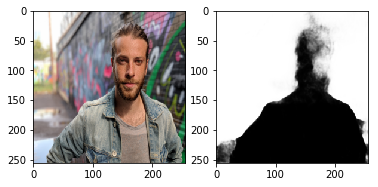

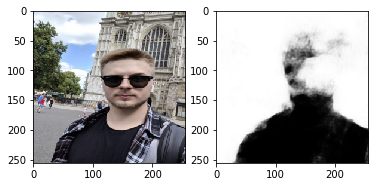

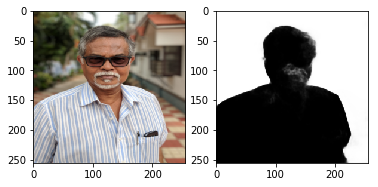

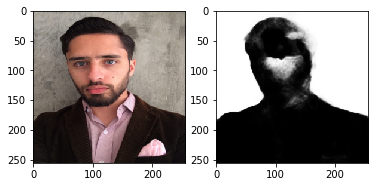

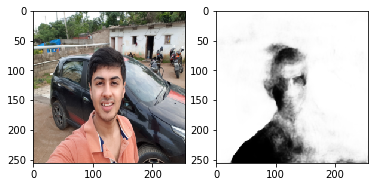

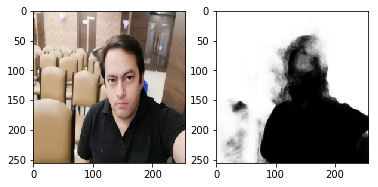

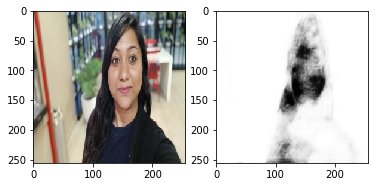

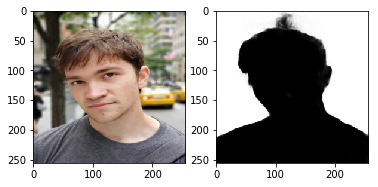

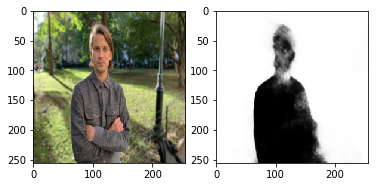

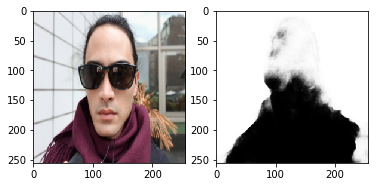

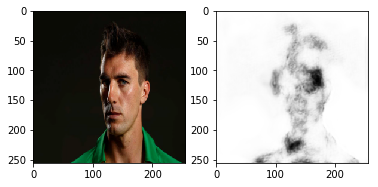

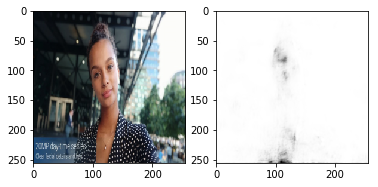

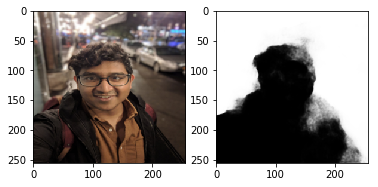

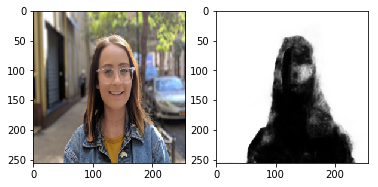

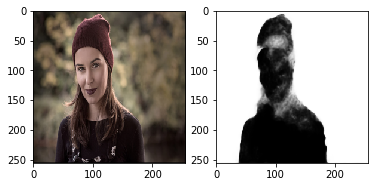

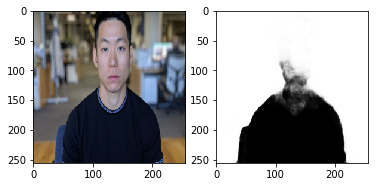

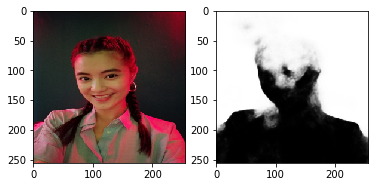

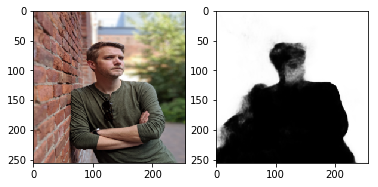

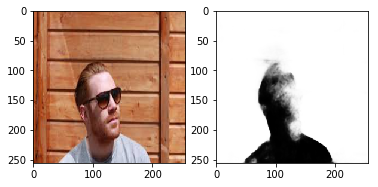

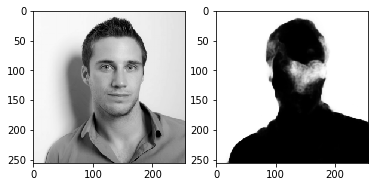

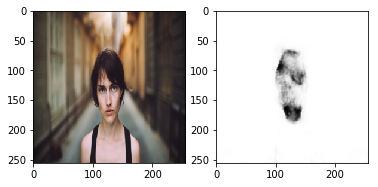

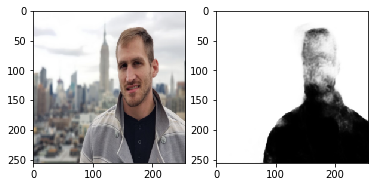

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
for inp,otp in zip(images,outs):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(skimage.transform.resize(inp,otp.shape,anti_aliasing=True))
    if NUM_CLASS>1:
        axarr[1].imshow(otp.argmax(axis=-1), cmap='Greys',  interpolation='nearest')
    else:
        axarr[1].imshow(otp*255, cmap='Greys',  interpolation='nearest')

In [24]:
for inp,otp in zip(images,outs):
    mask = skimage.transform.resize(otp,inp.shape[:2],preserve_range=True)
    #mask = cv2.resize(otp,inp.shape[:2])
    im = np.copy(inp)
    #mask[mask>0.3]=1
    #im[mask==0]=0
    im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(im)
    axarr[1].imshow(inp)

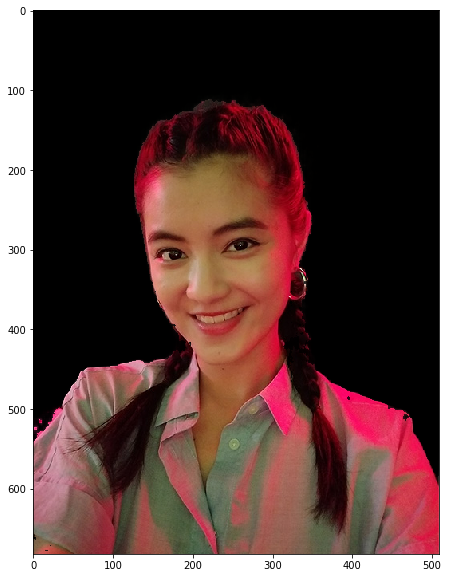

In [41]:
import random
i = random.choice(range(0,len(fnames)))
im = np.copy(images[i])
mask = skimage.transform.resize(outs[i],im.shape[:2],preserve_range=True)
mask[mask>0.3]=1
im = cv2.multiply(np.repeat(np.expand_dims(mask,axis=-1),3,axis=2).astype(float), im.astype(float))/255
#im[mask<0.3]=0
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(im)